
##Model-Agnostic Meta-Learning and PrototypicalNetworks


In [ ]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)
else:
    print("Data already downloaded")

assert os.path.isdir('./omniglot_resized')

# with gradient.Tape as tape:
#    ...

Unzipping...Done.


In [ ]:
""" Utility functions. """
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf

## Loss utilities
def cross_entropy_loss(pred, label, k_shot):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=tf.stop_gradient(label)) / k_shot)

def accuracy(labels, predictions):
  return tf.reduce_mean(tf.cast(tf.equal(labels, predictions), dtype=tf.float32))
    

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
"""Convolutional layers used by MAML model."""
## NOTE: You do not need to modify this block but you will need to use it.
seed = 123
def conv_block(inp, cweight, bweight, bn, activation=tf.nn.relu, residual=False):
  """ Perform, conv, batch norm, nonlinearity, and max pool """
  stride, no_stride = [1,2,2,1], [1,1,1,1]

  conv_output = tf.nn.conv2d(input=inp, filters=cweight, strides=no_stride, padding='SAME') + bweight
  normed = bn(conv_output)
  normed = activation(normed)
  return normed

class ConvLayers(tf.keras.layers.Layer):
  def __init__(self, channels, dim_hidden, dim_output, img_size):
    super(ConvLayers, self).__init__()
    self.channels = channels
    self.dim_hidden = dim_hidden
    self.dim_output = dim_output
    self.img_size = img_size

    weights = {}

    dtype = tf.float32
    weight_initializer =  tf.keras.initializers.GlorotUniform()
    k = 3

    weights['conv1'] = tf.Variable(weight_initializer(shape=[k, k, self.channels, self.dim_hidden]), name='conv1', dtype=dtype)
    weights['b1'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b1')
    self.bn1 = tf.keras.layers.BatchNormalization(name='bn1')
    weights['conv2'] = tf.Variable(weight_initializer(shape=[k, k, self.dim_hidden, self.dim_hidden]), name='conv2', dtype=dtype)
    weights['b2'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b2')
    self.bn2 = tf.keras.layers.BatchNormalization(name='bn2')
    weights['conv3'] = tf.Variable(weight_initializer(shape=[k, k, self.dim_hidden, self.dim_hidden]), name='conv3', dtype=dtype)
    weights['b3'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b3')
    self.bn3 = tf.keras.layers.BatchNormalization(name='bn3')
    weights['conv4'] = tf.Variable(weight_initializer([k, k, self.dim_hidden, self.dim_hidden]), name='conv4', dtype=dtype)
    weights['b4'] = tf.Variable(tf.zeros([self.dim_hidden]), name='b4')
    self.bn4 = tf.keras.layers.BatchNormalization(name='bn4')
    weights['w5'] = tf.Variable(weight_initializer(shape=[self.dim_hidden, self.dim_output]), name='w5', dtype=dtype)
    weights['b5'] = tf.Variable(tf.zeros([self.dim_output]), name='b5')
    self.conv_weights = weights

  def call(self, inp, weights):
    channels = self.channels
    inp = tf.reshape(inp, [-1, self.img_size, self.img_size, channels])
    hidden1 = conv_block(inp, weights['conv1'], weights['b1'], self.bn1)
    hidden2 = conv_block(hidden1, weights['conv2'], weights['b2'], self.bn2)
    hidden3 = conv_block(hidden2, weights['conv3'], weights['b3'], self.bn3)
    hidden4 = conv_block(hidden3, weights['conv4'], weights['b4'], self.bn4)
    hidden4 = tf.reduce_mean(input_tensor=hidden4, axis=[1, 2])
    return tf.matmul(hidden4, weights['w5']) + weights['b5']

In [ ]:
"""Data loading scripts"""
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc
import imageio

def get_images(paths, labels, n_samples=None, shuffle=True):
  """
  Takes a set of character folders and labels and returns paths to image files
  paired with labels.
  Args:
    paths: A list of character folders
    labels: List or numpy array of same length as paths
    n_samples: Number of images to retrieve per character
  Returns:
    List of (label, image_path) tuples
  """
  if n_samples is not None:
    sampler = lambda x: random.sample(x, n_samples)
  else:
    sampler = lambda x: x
  images_labels = [(i, os.path.join(path, image))
           for i, path in zip(labels, paths)
           for image in sampler(os.listdir(path))]
  if shuffle:
    random.shuffle(images_labels)
  return images_labels


def image_file_to_array(filename, dim_input):
  """
  Takes an image path and returns numpy array
  Args:
    filename: Image filename
    dim_input: Flattened shape of image
  Returns:
    1 channel image
  """
  image = imageio.imread(filename)
  image = image.reshape([dim_input])
  image = image.astype(np.float32) / 255.0
  image = 1.0 - image
  return image
  

class DataGenerator(object):
  """
  Data Generator capable of generating batches of Omniglot data.
  A "class" is considered a class of omniglot digits.
  """

  def __init__(self, num_classes, num_samples_per_class, num_meta_test_classes, num_meta_test_samples_per_class, config={}):
    """
    Args:
      num_classes: Number of classes for classification (K-way)
      num_samples_per_class: num samples to generate per class in one batch
      num_meta_test_classes: Number of classes for classification (K-way) at meta-test time
      num_meta_test_samples_per_class: num samples to generate per class in one batch at meta-test time
      batch_size: size of meta batch size (e.g. number of functions)
    """
    self.num_samples_per_class = num_samples_per_class
    self.num_classes = num_classes
    self.num_meta_test_samples_per_class = num_meta_test_samples_per_class
    self.num_meta_test_classes = num_meta_test_classes

    data_folder = config.get('data_folder', './omniglot_resized')
    self.img_size = config.get('img_size', (28, 28))

    self.dim_input = np.prod(self.img_size)
    self.dim_output = self.num_classes

    character_folders = [os.path.join(data_folder, family, character)
               for family in os.listdir(data_folder)
               if os.path.isdir(os.path.join(data_folder, family))
               for character in os.listdir(os.path.join(data_folder, family))
               if os.path.isdir(os.path.join(data_folder, family, character))]

    random.seed(123)
    random.shuffle(character_folders)
    num_val = 100
    num_train = 1100
    self.metatrain_character_folders = character_folders[: num_train]
    self.metaval_character_folders = character_folders[
      num_train:num_train + num_val]
    self.metatest_character_folders = character_folders[
      num_train + num_val:]

  def sample_batch(self, batch_type, batch_size, shuffle=True, swap=False):
    """
    Samples a batch for training, validation, or testing
    Args:
      batch_type: meta_train/meta_val/meta_test
      shuffle: randomly shuffle classes or not
      swap: swap number of classes (N) and number of samples per class (K) or not
    Returns:
      A a tuple of (1) Image batch and (2) Label batch where
      image batch has shape [B, N, K, 784] and label batch has shape [B, N, K, N] if swap is False
      where B is batch size, K is number of samples per class, N is number of classes
    """
    if batch_type == "meta_train":
      folders = self.metatrain_character_folders
      num_classes = self.num_classes
      num_samples_per_class = self.num_samples_per_class
    elif batch_type == "meta_val":
      folders = self.metaval_character_folders
      num_classes = self.num_classes
      num_samples_per_class = self.num_samples_per_class
    else:
      folders = self.metatest_character_folders
      num_classes = self.num_meta_test_classes
      num_samples_per_class = self.num_meta_test_samples_per_class
    all_image_batches, all_label_batches = [], []
    for i in range(batch_size):
      sampled_character_folders = random.sample(
        folders, num_classes)
      labels_and_images = get_images(sampled_character_folders, range(
        num_classes), n_samples=num_samples_per_class, shuffle=False)
      labels = [li[0] for li in labels_and_images]
      images = [image_file_to_array(
        li[1], self.dim_input) for li in labels_and_images]
      images = np.stack(images)
      labels = np.array(labels).astype(np.int32)
      labels = np.reshape(
        labels, (num_classes, num_samples_per_class))
      labels = np.eye(num_classes, dtype=np.float32)[labels]
      images = np.reshape(
        images, (num_classes, num_samples_per_class, -1))

      batch = np.concatenate([labels, images], 2)
      if shuffle:
        for p in range(num_samples_per_class):
          np.random.shuffle(batch[:, p])

      labels = batch[:, :, :num_classes]
      images = batch[:, :, num_classes:]

      if swap:
        labels = np.swapaxes(labels, 0, 1)
        images = np.swapaxes(images, 0, 1)

      all_image_batches.append(images)
      all_label_batches.append(labels)
    all_image_batches = np.stack(all_image_batches)
    all_label_batches = np.stack(all_label_batches)
    return all_image_batches, all_label_batches

In [ ]:
"""MAML model code"""
import numpy as np
import sys
import tensorflow as tf
from functools import partial


class MAML(tf.keras.Model):
  def __init__(self, dim_input=1, dim_output=1,
               num_inner_updates=1,
               inner_update_lr=0.4, num_filters=32, k_shot=5, learn_inner_update_lr=False):
    super(MAML, self).__init__()
    self.dim_input = dim_input
    self.dim_output = dim_output
    self.inner_update_lr = inner_update_lr
    self.loss_func = partial(cross_entropy_loss, k_shot=1)
    self.dim_hidden = num_filters
    self.channels = 1
    self.img_size = int(np.sqrt(self.dim_input/self.channels))

    # outputs_ts[i] and losses_ts_post[i] are the output and loss after i+1 inner gradient updates
    losses_tr_pre, outputs_tr, losses_ts_post, outputs_ts = [], [], [], []
    accuracies_tr_pre, accuracies_ts = [], []

    # for each loop in the inner training loop
    outputs_ts = [[]]*num_inner_updates
    losses_ts_post = [[]]*num_inner_updates
    accuracies_ts = [[]]*num_inner_updates

    # Define the weights - these should NOT be directly modified by the
    # inner training loop
    tf.random.set_seed(seed)
    self.conv_layers = ConvLayers(self.channels, self.dim_hidden, self.dim_output, self.img_size)

    self.learn_inner_update_lr = learn_inner_update_lr
    if self.learn_inner_update_lr:
      self.inner_update_lr_dict = {}
      for key in self.conv_layers.conv_weights.keys():
        self.inner_update_lr_dict[key] = [tf.Variable(self.inner_update_lr, name='inner_update_lr_%s_%d' % (key, j)) for j in range(num_inner_updates)]
  

  def call(self, inp, meta_batch_size=25, num_inner_updates=1):
    def task_inner_loop(inp, reuse=True,
                      meta_batch_size=25, num_inner_updates=1):
      """
        Perform gradient descent for one task in the meta-batch (i.e. inner-loop).
        Args:
          inp: a tuple (input_tr, input_ts, label_tr, label_ts), where input_tr and label_tr are the inputs and
            labels used for calculating inner loop gradients and input_ts and label_ts are the inputs and
            labels used for evaluating the model after inner updates.
            Should be shapes:
              input_tr: [N*K, 784]
              input_ts: [N*K, 784]
              label_tr: [N*K, N]
              label_ts: [N*K, N]
        Returns:
          task_output: a list of outputs, losses and accuracies at each inner update
      """
      # the inner and outer loop data
      input_tr, input_ts, label_tr, label_ts = inp

      # weights corresponds to the initial weights in MAML (i.e. the meta-parameters)
      weights = self.conv_layers.conv_weights

      # the predicted outputs, loss values, and accuracy for the pre-update model (with the initial weights)
      # evaluated on the inner loop training data
      task_output_tr_pre, task_loss_tr_pre, task_accuracy_tr_pre = None, None, None

      # lists to keep track of outputs, losses, and accuracies of test data for each inner_update
      # where task_outputs_ts[i], task_losses_ts[i], task_accuracies_ts[i] are the output, loss, and accuracy
      # after i+1 inner gradient updates
      task_outputs_ts, task_losses_ts, task_accuracies_ts = [], [], []
  
      #############################
      #### YOUR CODE GOES HERE ####
      # perform num_inner_updates to get modified weights
      # modified weights should be used to evaluate performance
      # Note that at each inner update, always use input_tr and label_tr for calculating gradients
      # and use input_ts and labels for evaluating performance

      # HINTS: You will need to use tf.GradientTape().
      # Read through the tf.GradientTape() documentation to see how 'persistent' should be set.
      # Here is some documentation that may be useful: 
      # https://www.tensorflow.org/guide/advanced_autodiff#higher-order_gradients
      # https://www.tensorflow.org/api_docs/python/tf/GradientTape

      # -------------------- Utility --------------------
      # Store a copy of the weights for inner-loop
      # inner_task_weights = dict(zip(weights.keys(), [weights[key] for key in weights.keys()]))

      # # Set the optimizer used for updating gradients
      # if not self.learn_inner_update_lr:
      #   optimizer = tf.keras.optimizers.SGD(learning_rate=self.inner_update_lr)
      # else:
      #   optimizer = tf.keras.optimizers.SGD(learning_rate=self.inner_update_lr)
      #   print("IMPLEMENT ME! [Part 4]")

      # -------------------- First Iter --------------------
      with tf.GradientTape(persistent=True) as inner_tape:
        # Compute prediction based on current weights
        task_output_tr_pre = self.conv_layers(input_tr, weights)
        # Compute inner-loop loss based on prediction
        task_loss_tr_pre = self.loss_func(task_output_tr_pre, label_tr)
        # print("[ITER ", str(0), "] DEBUG INNER-LOOP LOSS: ", task_loss_tr_pre)

      # Apply gradient w.r.t \theta on the current loss
      gradients = inner_tape.gradient(task_loss_tr_pre, weights)
      if self.learn_inner_update_lr:
        inner_task_weights = dict(zip(weights.keys(), [weights[key] - self.inner_update_lr_dict[key]*gradients[key] for key in weights.keys()]))
      else:
        inner_task_weights = dict(zip(weights.keys(), [weights[key] - self.inner_update_lr*gradients[key] for key in weights.keys()]))

      # Test new weights on test data and record results
      task_outputs_ts.append(self.conv_layers(input_ts, inner_task_weights))
      task_losses_ts.append(self.loss_func(task_outputs_ts[-1], label_ts))


      # -------------------- Other Iters --------------------
      for j in range(num_inner_updates-1):
        with tf.GradientTape(persistent=True) as inner_tape:
          # Compute prediction based on current weights
          pred = self.conv_layers(input_tr, inner_task_weights)
          # Compute inner-loop loss based on prediction
          curr_loss = self.loss_func(pred, label_tr)
          # print("[ITER ", j+1, "] DEBUG INNER-LOOP LOSS: ", curr_loss)

        # Apply gradient w.r.t \theta on the current loss
        gradients = inner_tape.gradient(curr_loss, inner_task_weights)
        if self.learn_inner_update_lr:
          inner_task_weights = dict(zip(weights.keys(), [weights[key] - self.inner_update_lr_dict[key]*gradients[key] for key in weights.keys()]))
        else:
          inner_task_weights = dict(zip(inner_task_weights.keys(), [inner_task_weights[key] - self.inner_update_lr*gradients[key] for key in inner_task_weights.keys()]))

        # Test new weights on test data and record results
        task_outputs_ts.append(self.conv_layers(input_ts, inner_task_weights))
        task_losses_ts.append(self.loss_func(task_outputs_ts[-1], label_ts))

      #############################

      # Compute accuracies from output predictions
      task_accuracy_tr_pre = accuracy(tf.argmax(input=label_tr, axis=1), tf.argmax(input=tf.nn.softmax(task_output_tr_pre), axis=1))

      for j in range(num_inner_updates):
        task_accuracies_ts.append(accuracy(tf.argmax(input=label_ts, axis=1), tf.argmax(input=tf.nn.softmax(task_outputs_ts[j]), axis=1)))

      task_output = [task_output_tr_pre, task_outputs_ts, task_loss_tr_pre, task_losses_ts, task_accuracy_tr_pre, task_accuracies_ts]

      return task_output

    input_tr, input_ts, label_tr, label_ts = inp
    # to initialize the batch norm vars, might want to combine this, and not run idx 0 twice.
    unused = task_inner_loop((input_tr[0], input_ts[0], label_tr[0], label_ts[0]),
                          False,
                          meta_batch_size,
                          num_inner_updates)
    out_dtype = [tf.float32, [tf.float32]*num_inner_updates, tf.float32, [tf.float32]*num_inner_updates]
    out_dtype.extend([tf.float32, [tf.float32]*num_inner_updates])
    task_inner_loop_partial = partial(task_inner_loop, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    result = tf.map_fn(task_inner_loop_partial,
                    elems=(input_tr, input_ts, label_tr, label_ts),
                    dtype=out_dtype,
                    parallel_iterations=meta_batch_size)
    return result
   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""Model training code"""
"""
Usage Instructions:
  5-way, 1-shot omniglot:
    python main.py --meta_train_iterations=15000 --meta_batch_size=25 --k_shot=1 --inner_update_lr=0.4 --num_inner_updates=1 --logdir=logs/omniglot5way/
  20-way, 1-shot omniglot:
    python main.py --meta_train_iterations=15000 --meta_batch_size=16 --k_shot=1 --n_way=20 --inner_update_lr=0.1 --num_inner_updates=5 --logdir=logs/omniglot20way/
  To run evaluation, use the '--meta_train=False' flag and the '--meta_test_set=True' flag to use the meta-test set.
"""
import csv
import numpy as np
import pickle
import random
import tensorflow as tf
import matplotlib.pyplot as plt

def outer_train_step(inp, model, optim, meta_batch_size=25, num_inner_updates=1):
  with tf.GradientTape(persistent=False) as outer_tape:
    result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result

    total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

  gradients = outer_tape.gradient(total_losses_ts[-1], model.trainable_variables)
  optim.apply_gradients(zip(gradients, model.trainable_variables))

  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

  return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts

def outer_eval_step(inp, model, meta_batch_size=25, num_inner_updates=1):
  result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

  outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result

  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

  return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts  


def meta_train_fn(model, exp_string, data_generator,
               n_way=5, meta_train_iterations=15000, meta_batch_size=25,
               log=True, logdir='/tmp/data', k_shot=1, num_inner_updates=1, meta_lr=0.001):
  SUMMARY_INTERVAL = 10
  SAVE_INTERVAL = 100
  PRINT_INTERVAL = 10  
  TEST_PRINT_INTERVAL = PRINT_INTERVAL*5

  print("-------------------- Classification Stats --------------------")
  print("n_way=", n_way)
  print("k_shot=", k_shot)
  print("-------------------- Classification Stats --------------------")
  pre_accuracies, post_accuracies = [], []

  num_classes = data_generator.num_classes

  optimizer = tf.keras.optimizers.Adam(learning_rate=meta_lr)

  meta_val_pre_accuracies_log = []
  meta_val_post_accuracies_log = []
  meta_val_iteration_key = []

  F_meta_val_pre_accuracies_log = open("drive/My Drive/meta_val_pre_accuracies_log.txt","w")
  F_meta_val_post_accuracies_log = open("drive/My Drive/meta_val_post_accuracies_log.txt","w")
  F_meta_val_iteration_key = open("drive/My Drive/meta_val_iteration_key.txt","w")

  for itr in range(meta_train_iterations):
    #############################
    #### YOUR CODE GOES HERE ####

    # sample a batch of training data and partition into
    # group a (input_tr, label_tr) and group b (input_ts, label_ts)
    # ---------------------------
    # EP: Start Implementation
    inputs, labels = data_generator.sample_batch('meta_train', meta_batch_size)
    # EP: Group A
    input_tr = inputs[:,:,0,:] 
    label_tr = labels[:,:,0,:] 

    # EP: Group B
    input_ts = inputs[:,:,1,:] 
    label_ts = labels[:,:,1,:] 

    #############################

    inp = (input_tr, input_ts, label_tr, label_ts)
    
    result = outer_train_step(inp, model, optimizer, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    if itr % SUMMARY_INTERVAL == 0:
      pre_accuracies.append(result[-2])
      post_accuracies.append(result[-1][-1])

    if (itr!=0) and itr % PRINT_INTERVAL == 0:
      print_str = 'Iteration %d: pre-inner-loop train accuracy: %.5f, post-inner-loop test accuracy: %.5f' % (itr, np.mean(pre_accuracies), np.mean(post_accuracies))
      print(print_str)
      pre_accuracies, post_accuracies = [], []

    if (itr!=0) and itr % TEST_PRINT_INTERVAL == 0:
      #############################
      #### YOUR CODE GOES HERE ####

      # sample a batch of validation data and partition into
      # training (input_tr, label_tr) and testing (input_ts, label_ts)
      # ---------------------------
      # EP: Start Implementation
      inputs, labels = data_generator.sample_batch('meta_val', meta_batch_size)
      # EP: Group A
      input_tr = inputs[:,:,0,:] 
      label_tr = labels[:,:,0,:] 

      # EP: Group B
      input_ts = inputs[:,:,1,:] 
      label_ts = labels[:,:,1,:] 
      #############################

      inp = (input_tr, input_ts, label_tr, label_ts)
      result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

      meta_val_pre_accuracies_log.append(result[-2])
      meta_val_post_accuracies_log.append(result[-1][-1])
      meta_val_iteration_key.append(itr)

      F_meta_val_pre_accuracies_log.write(str(result[-2])+ '\n')
      F_meta_val_post_accuracies_log.write(str(result[-1][-1])+ '\n')
      F_meta_val_iteration_key.write(str(itr)+ '\n')

      print('Meta-validation pre-inner-loop train accuracy: %.5f, meta-validation post-inner-loop test accuracy: %.5f' % (result[-2], result[-1][-1]))

  # Plot Results
  plt.figure(figsize=(12,8))
  plt.plot(meta_val_iteration_key, meta_val_pre_accuracies_log, label="pre-acc")
  plt.plot(meta_val_iteration_key, meta_val_post_accuracies_log, label="post-acc")
  plt.title("Meta-val results for lr="+str(model.inner_update_lr))
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.ylim([0,1])
  plt.grid()
  plt.legend()

  F_meta_val_pre_accuracies_log.close()
  F_meta_val_post_accuracies_log.close()
  F_meta_val_iteration_key.close()

  # Save Results
  np.save("drive/My Drive/meta_val_pre_accuracies_log.npy", np.array(meta_val_pre_accuracies_log))
  np.save("drive/My Drive/meta_val_post_accuracies_log.npy", np.array(meta_val_post_accuracies_log))
  np.save("drive/My Drive/meta_val_iteration_key.npy", np.array(meta_val_iteration_key))

  model_file = logdir + '/' + exp_string +  '/model' + str(itr)
  print("Saving to ", model_file)
  model.save_weights(model_file)

# calculated for omniglot
NUM_META_TEST_POINTS = 600

def meta_test_fn(model, data_generator, n_way=5, meta_batch_size=25, k_shot=1,
              num_inner_updates=1):
  
  num_classes = data_generator.num_classes

  np.random.seed(1)
  random.seed(1)

  meta_test_accuracies = []

  for _ in range(NUM_META_TEST_POINTS):
    #############################
    #### YOUR CODE GOES HERE ####

    # sample a batch of test data and partition into
    # group a (input_tr, label_tr) and group b (input_ts, label_ts)
    # EP: Start Implementation
    inputs, labels = data_generator.sample_batch('meta_test', meta_batch_size)
    # EP: Group A
    input_tr = inputs[:,:,0,:] 
    label_tr = labels[:,:,0,:] 

    # EP: Group B
    input_ts = inputs[:,:,1,:]
    label_ts = labels[:,:,1,:] 
    #############################
    inp = (input_tr, input_ts, label_tr, label_ts)
    result = outer_eval_step(inp, model, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    meta_test_accuracies.append(result[-1][-1])

  meta_test_accuracies = np.array(meta_test_accuracies)
  means = np.mean(meta_test_accuracies)
  stds = np.std(meta_test_accuracies)
  ci95 = 1.96*stds/np.sqrt(NUM_META_TEST_POINTS)

  print('Mean meta-test accuracy/loss, stddev, and confidence intervals')
  print((means, stds, ci95))


def run_maml(n_way=5, k_shot=1, meta_batch_size=25, meta_lr=0.001,
             inner_update_lr=0.4, num_filters=32, num_inner_updates=1,
             learn_inner_update_lr=False,
             resume=False, resume_itr=0, log=True, logdir='/tmp/data',
             data_path='./omniglot_resized',meta_train=True,
             meta_train_iterations=15000, meta_train_k_shot=-1,
             meta_train_inner_update_lr=-1):


  # call data_generator and get data with k_shot*2 samples per class
  data_generator = DataGenerator(n_way, k_shot*2, n_way, k_shot*2, config={'data_folder': data_path})

  # set up MAML model
  dim_output = data_generator.dim_output
  dim_input = data_generator.dim_input
  model = MAML(dim_input,
              dim_output,
              num_inner_updates=num_inner_updates,
              inner_update_lr=inner_update_lr,
              k_shot=k_shot,
              num_filters=num_filters,
              learn_inner_update_lr=learn_inner_update_lr)

  if meta_train_k_shot == -1:
    meta_train_k_shot = k_shot
  if meta_train_inner_update_lr == -1:
    meta_train_inner_update_lr = inner_update_lr

  exp_string = 'cls_'+str(n_way)+'.mbs_'+str(meta_batch_size) + '.k_shot_' + str(meta_train_k_shot) + '.inner_numstep_' + str(num_inner_updates) + '.inner_updatelr_' + str(meta_train_inner_update_lr) + '.learn_inner_update_lr_' + str(learn_inner_update_lr)


  if meta_train:
    meta_train_fn(model, exp_string, data_generator,
                  n_way, meta_train_iterations, meta_batch_size, log, logdir,
                  k_shot, num_inner_updates, meta_lr)
  else:
    meta_batch_size = 1

    model_file = tf.train.latest_checkpoint(logdir + '/' + exp_string)
    print("Restoring model weights from ", model_file)
    model.load_weights(model_file)

    meta_test_fn(model, data_generator, n_way, meta_batch_size, k_shot, num_inner_updates)
  

In [ ]:
run_maml(n_way=5, k_shot=1, inner_update_lr=4.0, num_inner_updates=1, learn_inner_update_lr=True)

cls_5.mbs_25.k_shot_1.inner_numstep_1.inner_updatelr_4.0.learn_inner_update_lr_True
-------------------- Classification Stats --------------------
n_way= 5
k_shot= 1
-------------------- Classification Stats --------------------


KeyboardInterrupt: ignored

In [ ]:
run_maml(n_way=5, k_shot=1, inner_update_lr=4.0, num_inner_updates=1, learn_inner_update_lr=True, meta_train=False)

In [ ]:
run_maml(n_way=5,k_shot=10,inner_update_lr=0.4,num_inner_updates=1,meta_train=False, meta_train_k_shot=1)

In [ ]:
# models/ProtoNet
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

class ProtoNet(tf.keras.Model):

  def __init__(self, num_filters, latent_dim):
    super(ProtoNet, self).__init__()
    self.num_filters = num_filters
    self.latent_dim = latent_dim
    num_filter_list = self.num_filters + [latent_dim]
    self.convs = []
    for i, num_filter in enumerate(num_filter_list):
      block_parts = [
        layers.Conv2D(
          filters=num_filter,
          kernel_size=3,
          padding='SAME',
          activation='linear'),
      ]

      block_parts += [layers.BatchNormalization()]
      block_parts += [layers.Activation('relu')]
      block_parts += [layers.MaxPool2D()]
      block = tf.keras.Sequential(block_parts, name='conv_block_%d' % i)
      self.__setattr__("conv%d" % i, block)
      self.convs.append(block)
    self.flatten = tf.keras.layers.Flatten()

  def call(self, inp):
    out = inp
    for conv in self.convs:
      out = conv(out)
    out = self.flatten(out)
    return out

def ProtoLoss(x_latent, q_latent, labels_onehot, num_classes, num_support, num_queries):
  """
    calculates the prototype network loss using the latent representation of x
    and the latent representation of the query set
    Args:
      x_latent: latent representation of supports with shape [N*S, D], where D is the latent dimension
      q_latent: latent representation of queries with shape [N*Q, D], where D is the latent dimension
      labels_onehot: one-hot encodings of the labels of the queries with shape [N, Q, N]
      num_classes: number of classes (N) for classification
      num_support: number of examples (S) in the support set
      num_queries: number of examples (Q) in the query set
    Returns:
      ce_loss: the cross entropy loss between the predicted labels and true labels
      acc: the accuracy of classification on the queries
  """
  #############################
  #### YOUR CODE GOES HERE ####

  # compute the prototypes
  # compute the distance from the prototypes
  # compute cross entropy loss
  # note - additional steps are needed!
  # return the cross-entropy loss and accuracy

  #############################

  # ------------------
  # Compute Prototypes
  # ------------------
  x_latent_labels = labels_onehot[:,:,:num_support,:].squeeze()
  q_latent_labels = labels_onehot[:,:,-1*num_queries:,:].squeeze()

  # print(x_latent.shape)
  latent_sets = []
  for idx in range(x_latent.shape[0]//num_support):
    # print(idx, idx*num_support, (idx+1)*num_support)
    latent_sets.append(tf.reduce_mean(x_latent[idx*num_support:(idx+1)*num_support], axis = 0))
    # print(x_latent[idx*num_support:(idx+1)*num_support].shape)
    # print(latent_sets.shape)


  # latent_sets = np.zeros((num_classes, x_latent.shape[1]))
  # K = np.zeros(num_classes)
  # for idx, latent in enumerate(x_latent):
  #   curr_label = x_latent_labels[idx]
  #   label_idx = int(np.where(curr_label==1)[0]) # Which index has the 1?
  #   latent_sets[label_idx] += latent
  #   K[label_idx]+=1
  # latent_sets = np.transpose(np.transpose(latent_sets) / K)
  # latent_sets = latent_sets + tf.random.uniform(shape=[1], maxval=0.001, dtype=tf.float32)

  # print("[PROTOLOSS] latent_sets.shape=", latent_sets.shape)

  # Compute distances between prototypes and queries, convert to logits

  # distances_old = np.zeros((q_latent.shape[0], num_classes))
  # # print(type(q_latent))
  # # correct_labels = np.zeros(q_latent.shape[0], dtype=np.int)
  # # temp_q_labels = q_latent_labels.reshape(q_latent.shape[0], num_classes)
  # for query_idx, query_val in enumerate(q_latent):
  #   for support_idx, support_val in enumerate(latent_sets):
  #     distances_old[query_idx, support_idx] = np.sqrt(np.dot((query_val-support_val),(query_val-support_val)))
  #   # correct_labels[query_idx] = int(np.where(temp_q_labels[query_idx]==1)[0])
  

  delta = q_latent - latent_sets[0]
  distances = tf.math.reduce_euclidean_norm(delta, 1, keepdims=True)

  for support_idx in range(num_classes-1):
    delta = q_latent - latent_sets[support_idx+1]
    delta = tf.math.reduce_euclidean_norm(delta, 1, keepdims=True)
    distances = tf.concat([distances, delta], 1)


  correct_labels = np.zeros(q_latent.shape[0], dtype=np.int)
  q_latent_labels_reshaped = q_latent_labels.reshape(q_latent.shape[0], num_classes)
  for query_idx in range(q_latent.shape[0]):
    correct_labels[query_idx] = int(np.where(q_latent_labels_reshaped[query_idx]==1)[0])

  # Compute accuracies 
  decisions = np.argmin(distances, axis=1)
  result = len(np.where(decisions-correct_labels == 0)[0])
  acc = result/q_latent.shape[0]


  loss_fn = partial(cross_entropy_loss, k_shot=1)
  ce_loss = loss_fn(-1*distances, q_latent_labels_reshaped)

  # # Compute cross entropy loss
  # ce_loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=correct_labels.squeeze(), logits=-1*distances))

  return ce_loss, acc

In [ ]:
# run_ProtoNet
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os
import glob
import matplotlib.pyplot as plt

def proto_net_train_step(model, optim, x, q, labels_ph):
  num_classes, num_support, im_height, im_width, channels = x.shape
  num_queries = q.shape[1]
  x = tf.reshape(x, [-1, im_height, im_width, channels])
  q = tf.reshape(q, [-1, im_height, im_width, channels])

  with tf.GradientTape() as tape:
    x_latent = model(x)
    q_latent = model(q)
    ce_loss, acc = ProtoLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries)

  gradients = tape.gradient(ce_loss, model.trainable_variables)
  optim.apply_gradients(zip(gradients, model.trainable_variables))
  return ce_loss, acc

def proto_net_eval(model, x, q, labels_ph):
  num_classes, num_support, im_height, im_width, channels = x.shape
  num_queries = q.shape[1]
  x = tf.reshape(x, [-1, im_height, im_width, channels])
  q = tf.reshape(q, [-1, im_height, im_width, channels])

  x_latent = model(x)
  q_latent = model(q)
  ce_loss, acc = ProtoLoss(x_latent, q_latent, labels_ph, num_classes, num_support, num_queries)

  return ce_loss, acc 

def run_protonet(data_path='./omniglot_resized', n_way=20, k_shot=1, n_query=5, n_meta_test_way=20, k_meta_test_shot=5, n_meta_test_query=5):
  n_epochs = 20
  n_episodes = 100

  im_width, im_height, channels = 28, 28, 1
  num_filters = 32
  latent_dim = 16
  num_conv_layers = 3
  n_meta_test_episodes = 1000

  model = ProtoNet([num_filters]*num_conv_layers, latent_dim)
  optimizer = tf.keras.optimizers.Adam()

  meta_val_accuracies_log = []
  meta_val_iteration_key = []

    # call DataGenerator with k_shot+n_query samples per class
  data_generator = DataGenerator(n_way, k_shot+n_query, n_meta_test_way, k_meta_test_shot+n_meta_test_query)
  for ep in range(n_epochs):
    for epi in range(n_episodes):
      #############################
      #### YOUR CODE GOES HERE ####

      # sample a batch of training data and partition into
      # support and query sets

      # ---------------------------
      # EP: Start Implementation
      inputs, labels = data_generator.sample_batch('meta_train', 1, shuffle=False)
      # print("labels shape: ", labels.shape)
      # print(labels)

      # EP: Support
      support = tf.reshape(inputs[:,:,:k_shot,:], [inputs.shape[1], k_shot, im_width, im_height, channels])
      # label_support = labels[:,:,:k_shot,:] 

      # EP: Query
      query = tf.reshape(inputs[:,:,-1*n_query:,:], [inputs.shape[1], n_query, im_width, im_height, channels])
      # label_query = labels[:,:,-1*n_query:,:]
      # ---------------------------

      #############################
      ls, ac = proto_net_train_step(model, optimizer, x=support, q=query, labels_ph=labels)
      if (epi+1) % 50 == 0:
        #############################
        #### YOUR CODE GOES HERE ####

        # sample a batch of validation data and partition into
        # support and query sets

        # ---------------------------
        # EP: Start Implementation
        inputs, labels = data_generator.sample_batch('meta_val', 1, shuffle=False)

        # EP: Support
        support = tf.reshape(inputs[:,:,:k_shot,:], [inputs.shape[1], k_shot, im_width, im_height, channels])
        # label_support = labels[:,:,:k_shot,:] 

        # EP: Query
        query = tf.reshape(inputs[:,:,-1*n_query:,:], [inputs.shape[1], n_query, im_width, im_height, channels])
        # label_query = labels[:,:,-1*n_query:,:]
        # ---------------------------

        #############################
        val_ls, val_ac = proto_net_eval(model, x=support, q=query, labels_ph=labels)
        print('[epoch {}/{}, episode {}/{}] => meta-training loss: {:.5f}, meta-training acc: {:.5f}, meta-val loss: {:.5f}, meta-val acc: {:.5f}'.format(ep+1,
                                                                    n_epochs,
                                                                    epi+1,
                                                                    n_episodes,
                                                                    ls,
                                                                    ac,
                                                                    val_ls,
                                                                    val_ac))

        meta_val_accuracies_log.append(val_ac)
        meta_val_iteration_key.append(ep*100 + epi)

  # Plot Results
  plt.figure(figsize=(12,8))
  plt.plot(meta_val_iteration_key, meta_val_accuracies_log, label="val_acc")
  plt.title("Prototypical Network Meta-val results")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.ylim([0,1])
  plt.grid()
  plt.legend()
      
  print('Testing...')
  meta_test_accuracies = []
  for epi in range(n_meta_test_episodes):
    #############################
    #### YOUR CODE GOES HERE ####

    # sample a batch of test data and partition into
    # support and query sets

    # ---------------------------
    # EP: Start Implementation
    inputs, labels = data_generator.sample_batch('meta_test', 1, shuffle=False)

    # EP: Support
    support = tf.reshape(inputs[:,:,:k_shot,:], [inputs.shape[1], k_shot, im_width, im_height, channels])
    # label_support = labels[:,:,:k_shot,:] 

    # EP: Query
    query = tf.reshape(inputs[:,:,-1*n_query:,:], [inputs.shape[1], n_query, im_width, im_height, channels])
    # label_query = labels[:,:,-1*n_query:,:]
    # ---------------------------

    #############################
    ls, ac = proto_net_eval(model, x=support, q=query, labels_ph=labels)
    meta_test_accuracies.append(ac)
    if (epi+1) % 50 == 0:
      print('[meta-test episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(epi+1, n_meta_test_episodes, ls, ac))
  avg_acc = np.mean(meta_test_accuracies)
  stds = np.std(meta_test_accuracies)
  print('Average Meta-Test Accuracy: {:.5f}, Meta-Test Accuracy Std: {:.5f}'.format(avg_acc, stds))

[epoch 1/20, episode 50/100] => meta-training loss: 1.03733, meta-training acc: 0.56000, meta-val loss: 0.51639, meta-val acc: 0.88000
[epoch 1/20, episode 100/100] => meta-training loss: 0.27666, meta-training acc: 0.96000, meta-val loss: 0.39981, meta-val acc: 0.84000
[epoch 2/20, episode 50/100] => meta-training loss: 0.40146, meta-training acc: 0.84000, meta-val loss: 0.35827, meta-val acc: 0.88000
[epoch 2/20, episode 100/100] => meta-training loss: 0.32942, meta-training acc: 0.84000, meta-val loss: 0.35543, meta-val acc: 0.88000
[epoch 3/20, episode 50/100] => meta-training loss: 0.63637, meta-training acc: 0.80000, meta-val loss: 0.53028, meta-val acc: 0.80000
[epoch 3/20, episode 100/100] => meta-training loss: 0.34434, meta-training acc: 0.88000, meta-val loss: 0.34937, meta-val acc: 0.84000
[epoch 4/20, episode 50/100] => meta-training loss: 0.50130, meta-training acc: 0.84000, meta-val loss: 1.09815, meta-val acc: 0.60000
[epoch 4/20, episode 100/100] => meta-training loss:

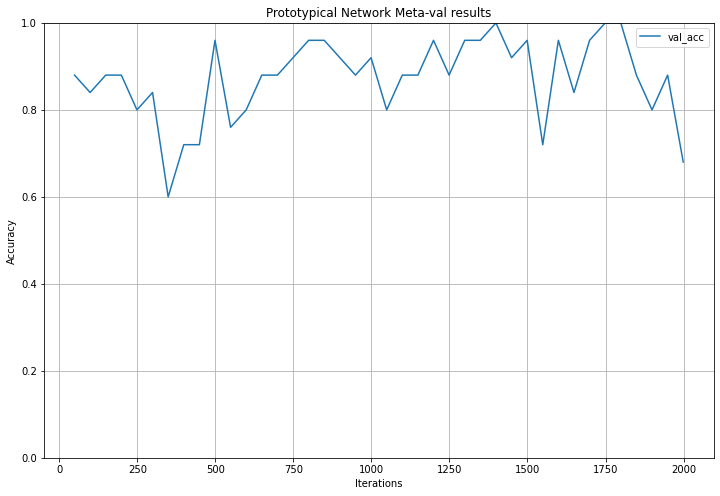

In [ ]:
run_protonet('./omniglot_resized/', n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, k_meta_test_shot=6, n_meta_test_query=4)